In [54]:
from sklearn import preprocessing, metrics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import RepeatVector,TimeDistributed
from numpy import array
from keras.models import Sequential, load_model
#import utils_paths
import re
from tqdm import tqdm
import os

import warnings
warnings.simplefilter("ignore")


In [20]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\calendar.csv
./data\sales_train_validation.csv
./data\sample_submission.csv
./data\sell_prices.csv


In [21]:
train_sales = pd.read_csv('./data/sales_train_validation.csv')
calendar = pd.read_csv('./data/calendar.csv')
sell_prices = pd.read_csv('./data/sell_prices.csv')
submission_file = pd.read_csv('./data/sample_submission.csv')

In [22]:
train_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [23]:
train_sales.shape

(30490, 1919)

In [24]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [25]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [26]:
submission_file.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
num = 30490 # number of traindata

In [28]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1',
                    'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['event_name_1','event_type_1','event_name_2',
           'event_type_2','snap_CA','snap_TX','snap_WI']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [35]:
days = range(1, 1970)
time_series_columns = [f'd_{i}' for i in days]
transfer_cal = pd.DataFrame(calendar[['event_name_1',
                                      'event_type_1',
                                      'event_name_2',
                                      'event_type_2',
                                      'snap_CA',
                                      'snap_TX',
                                      'snap_WI']].values.T, index=['event_name_1',
                                                                   'event_type_1',
                                                                   'event_name_2',
                                                                   'event_type_2',
                                                                   'snap_CA',
                                                                   'snap_TX',
                                                                   'snap_WI'], columns= time_series_columns)
transfer_cal = transfer_cal.fillna(0)
event_name_1_se = transfer_cal.loc['event_name_1'].apply(lambda x: x if re.search("^\d+$", 
                                                                                  str(x)) else np.nan).fillna(10)
event_name_2_se = transfer_cal.loc['event_name_2'].apply(lambda x: x if re.search("^\d+$", 
                                                                                  str(x)) else np.nan).fillna(10)

In [36]:
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[calendar['date']>= '2016-1-27']  #reduce memory
calendar= transform(calendar)
# Attempts to convert events into time series data.
transfer_cal = pd.DataFrame(calendar[['event_name_1','event_type_1',
                                      'event_name_2',
                                      'event_type_2',
                                      'snap_CA',
                                      'snap_TX',
                                      'snap_WI']].values.T,
                            index=['event_name_1',
                                   'event_type_1',
                                   'event_name_2',
                                   'event_type_2',
                                   'snap_CA',
                                   'snap_TX',
                                   'snap_WI'])
transfer_cal

C:\Users\kt347\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\kt347\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
event_name_1,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,6
event_type_1,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,3
event_name_2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
event_type_2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
snap_CA,0,0,0,0,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
snap_TX,0,0,0,0,0,1,0,1,0,1,...,0,1,1,1,0,1,0,0,0,0
snap_WI,0,0,0,0,0,0,1,1,0,1,...,0,1,1,0,1,1,0,0,0,0


In [37]:
price_fea = calendar[['wm_yr_wk','date']].merge(sell_prices, on = ['wm_yr_wk'],
                                                how = 'left')
price_fea['id'] = price_fea['item_id']+'_'+price_fea['store_id']+'_validation'
df = price_fea.pivot('id','date','sell_price')

In [38]:
price_fea.head()

,wm_yr_wk,date,store_id,item_id,sell_price,id
0,11552,2016-01-27,CA_1,HOBBIES_1_001,8.26,HOBBIES_1_001_CA_1_validation
1,11552,2016-01-27,CA_1,HOBBIES_1_002,3.97,HOBBIES_1_002_CA_1_validation
2,11552,2016-01-27,CA_1,HOBBIES_1_003,2.97,HOBBIES_1_003_CA_1_validation
3,11552,2016-01-27,CA_1,HOBBIES_1_004,4.64,HOBBIES_1_004_CA_1_validation
4,11552,2016-01-27,CA_1,HOBBIES_1_005,2.88,HOBBIES_1_005_CA_1_validation


In [39]:
df.head()

date,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,...,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_2_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_3_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_4_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_TX_1_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24


In [41]:
df.tail()

date,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,...,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
id,,,,,,,,,,,,,,,,,,,,,
HOUSEHOLD_2_516_TX_2_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94
HOUSEHOLD_2_516_TX_3_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94
HOUSEHOLD_2_516_WI_1_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94
HOUSEHOLD_2_516_WI_2_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94
HOUSEHOLD_2_516_WI_3_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94


In [40]:
price_df = train_sales.merge(df,on=['id'],how= 'left').iloc[:,-145:]
price_df.index = train_sales.id
price_df.head()

,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,...,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,8.26,...,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38,8.38
HOBBIES_1_002_CA_1_validation,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,...,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97,3.97
HOBBIES_1_003_CA_1_validation,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,...,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97,2.97
HOBBIES_1_004_CA_1_validation,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,...,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64,4.64
HOBBIES_1_005_CA_1_validation,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,...,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88,2.88


In [42]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = train_sales[time_series_columns]  #Get time series data

In [44]:
time_series_columns

['d_1',
 'd_2',
 'd_3',
 'd_4',
 'd_5',
 'd_6',
 'd_7',
 'd_8',
 'd_9',
 'd_10',
 'd_11',
 'd_12',
 'd_13',
 'd_14',
 'd_15',
 'd_16',
 'd_17',
 'd_18',
 'd_19',
 'd_20',
 'd_21',
 'd_22',
 'd_23',
 'd_24',
 'd_25',
 'd_26',
 'd_27',
 'd_28',
 'd_29',
 'd_30',
 'd_31',
 'd_32',
 'd_33',
 'd_34',
 'd_35',
 'd_36',
 'd_37',
 'd_38',
 'd_39',
 'd_40',
 'd_41',
 'd_42',
 'd_43',
 'd_44',
 'd_45',
 'd_46',
 'd_47',
 'd_48',
 'd_49',
 'd_50',
 'd_51',
 'd_52',
 'd_53',
 'd_54',
 'd_55',
 'd_56',
 'd_57',
 'd_58',
 'd_59',
 'd_60',
 'd_61',
 'd_62',
 'd_63',
 'd_64',
 'd_65',
 'd_66',
 'd_67',
 'd_68',
 'd_69',
 'd_70',
 'd_71',
 'd_72',
 'd_73',
 'd_74',
 'd_75',
 'd_76',
 'd_77',
 'd_78',
 'd_79',
 'd_80',
 'd_81',
 'd_82',
 'd_83',
 'd_84',
 'd_85',
 'd_86',
 'd_87',
 'd_88',
 'd_89',
 'd_90',
 'd_91',
 'd_92',
 'd_93',
 'd_94',
 'd_95',
 'd_96',
 'd_97',
 'd_98',
 'd_99',
 'd_100',
 'd_101',
 'd_102',
 'd_103',
 'd_104',
 'd_105',
 'd_106',
 'd_107',
 'd_108',
 'd_109',
 'd_110',
 'd_111'

In [46]:
time_series_data.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


(28,)


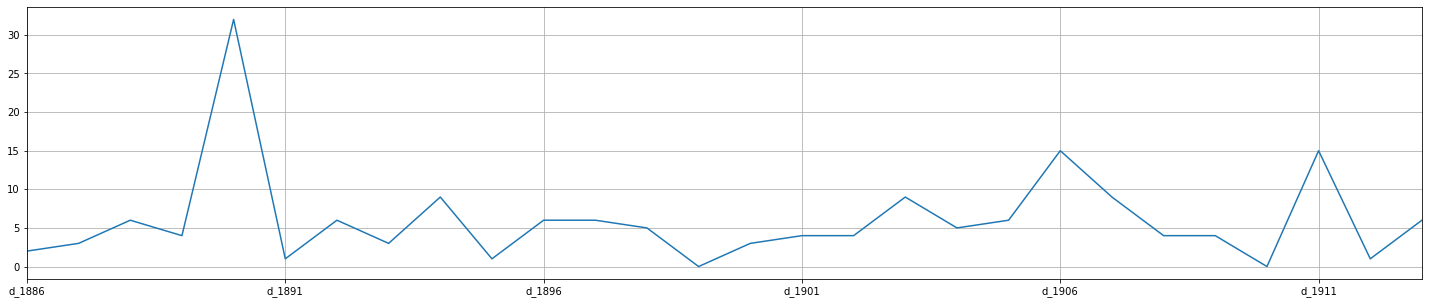

In [47]:
#show last 28days
figsize = (25, 5)
time_series_data.iloc[15, -28:].plot(figsize=figsize)

plt.grid()
#The last 28 days
print(time_series_data.iloc[0, 1885:].shape)

(28,)


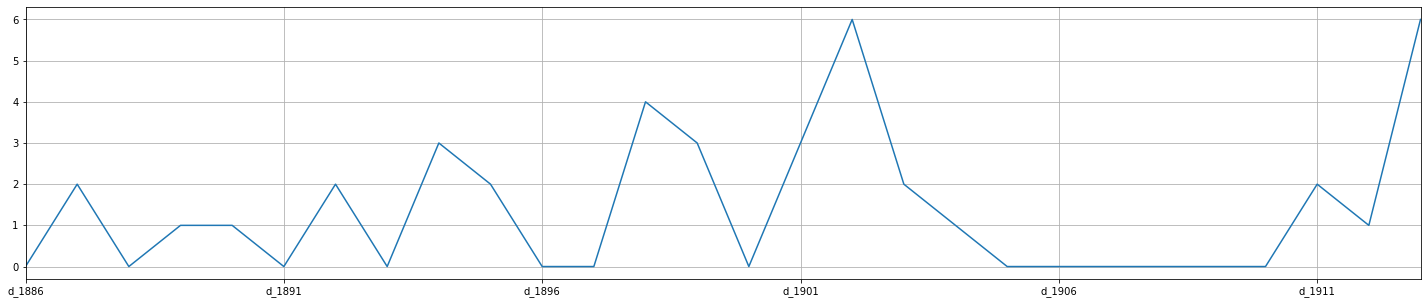

In [48]:
#show last 28days
figsize = (25, 5)
time_series_data.iloc[16, -28:].plot(figsize=figsize)

plt.grid()
#The last 28 days
print(time_series_data.iloc[0, 1885:].shape)

In [49]:
def min_max(df):
    return (df-df.mean())/df.std()  #scale

In [50]:
calendar = pd.read_csv('./data/calendar.csv')

C:\Users\kt347\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\kt347\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\kt347\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\kt347\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


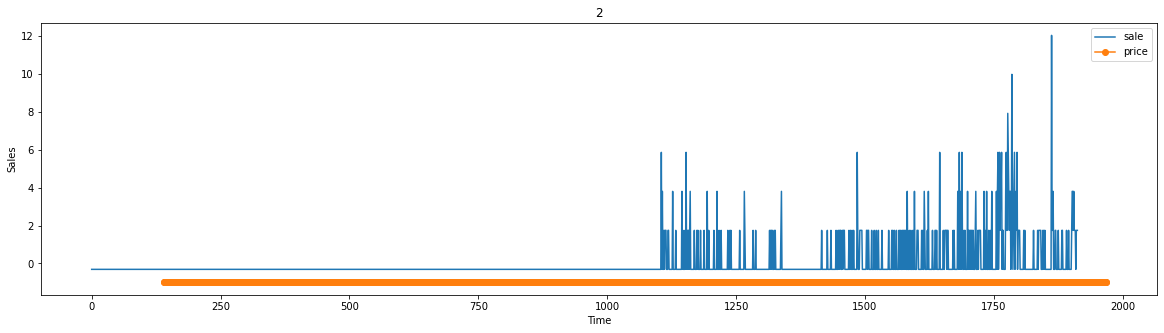

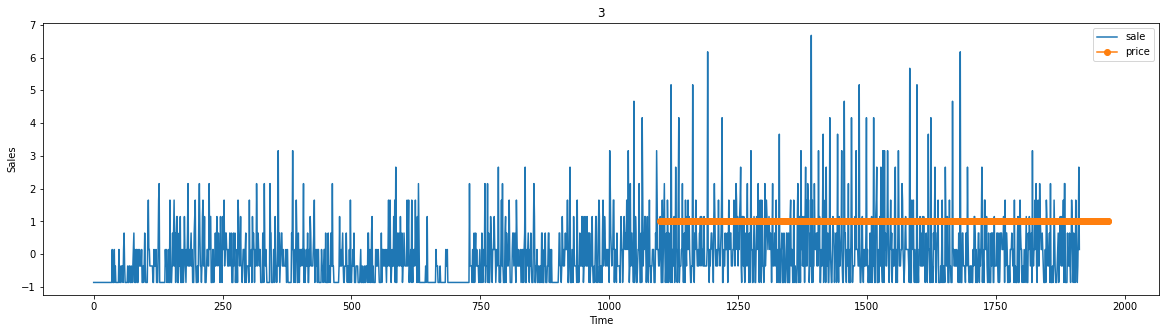

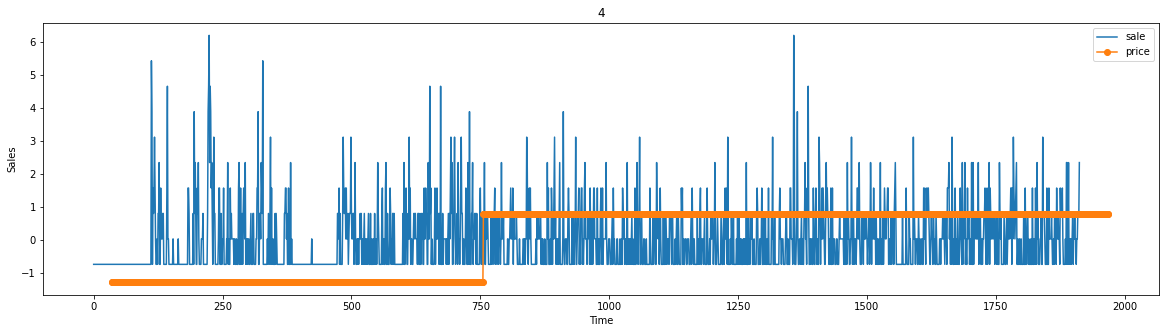

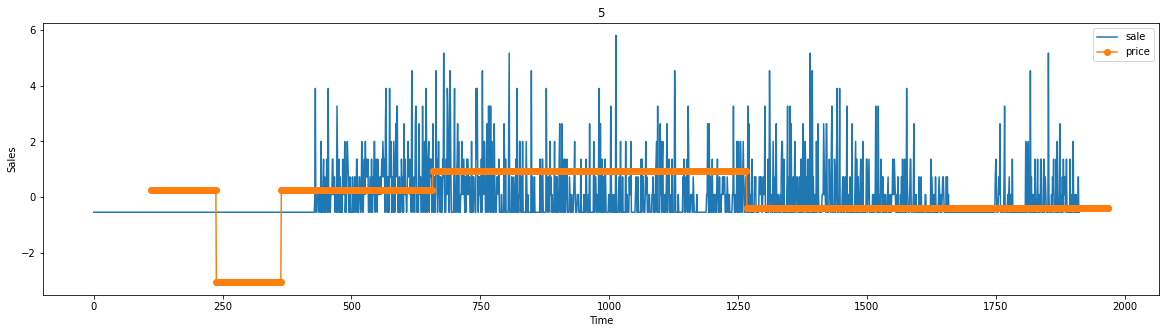

In [51]:
for i in range(2,6):
    price_sell = calendar.merge(sell_prices[sell_prices.item_id=='HOBBIES_1_00'+str(i)][sell_prices.store_id=='CA_1'], on = ['wm_yr_wk'], how = 'left')
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(min_max(time_series_data.iloc[i].values))
    ax.plot(min_max(price_sell.sell_price),'-o')
    plt.legend(['sale','price'])
    ax.set_title(str(i))
    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

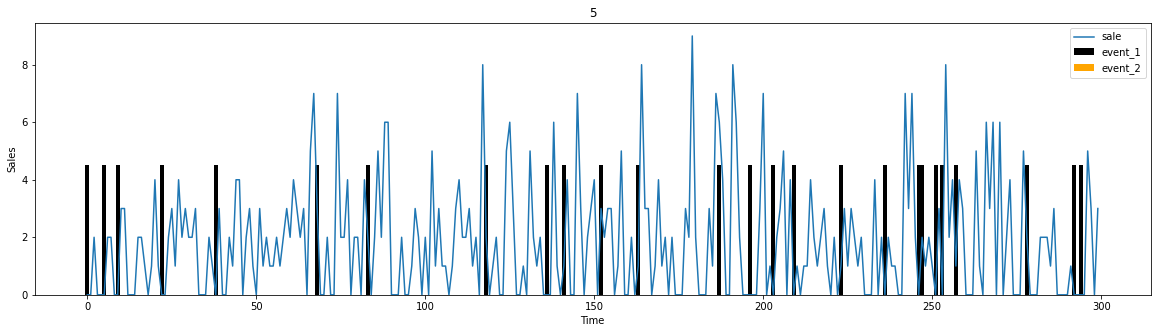

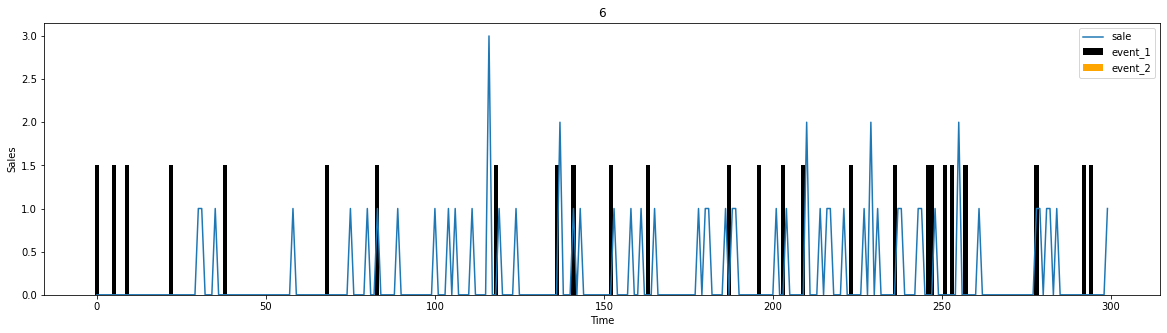

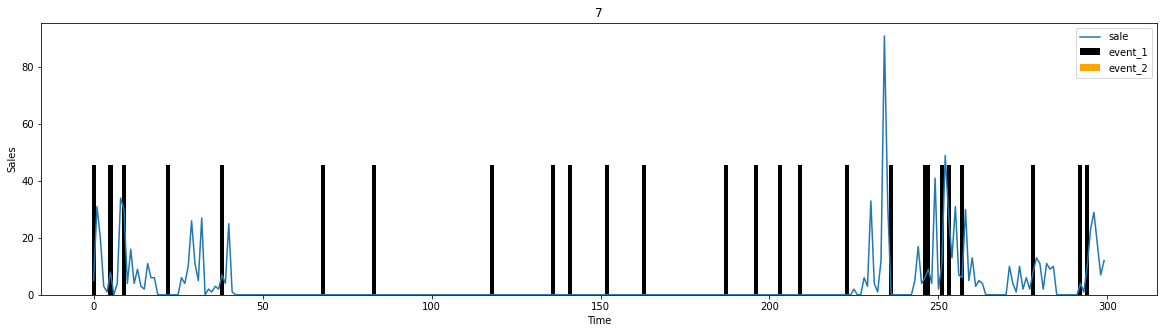

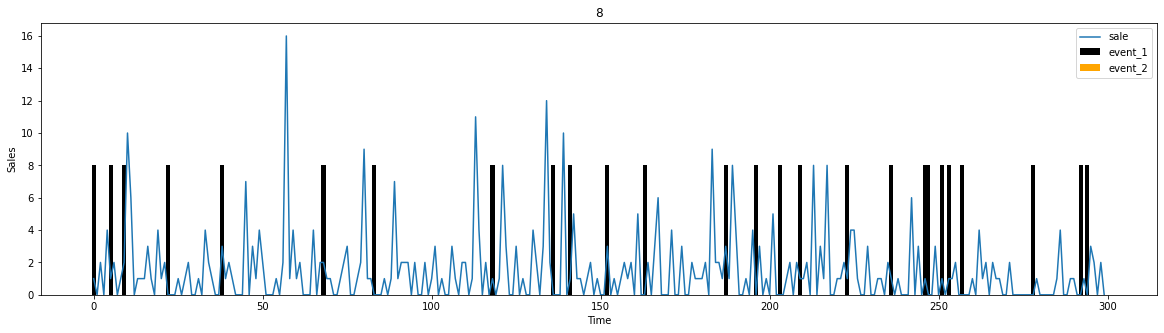

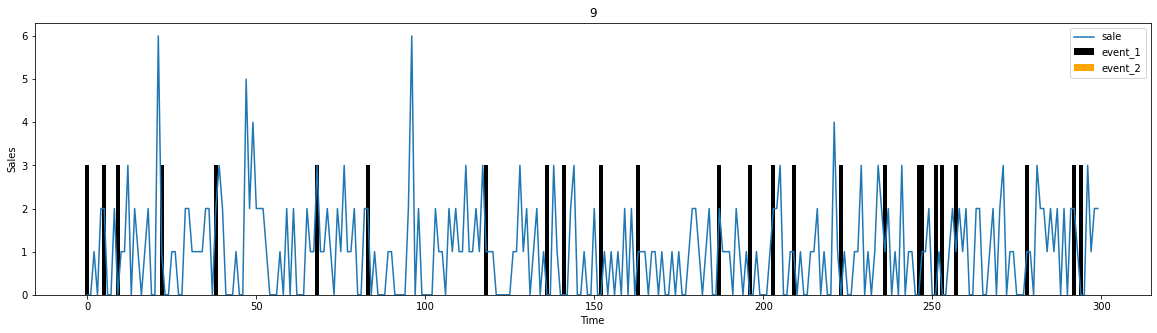

In [52]:
for i in range(5,10):
    fig =plt.figure(figsize= (20, 5))
    ax = fig.add_subplot(1, 1, 1)
    #ax.bar(x = range(len(transfer_cal.loc['snap_WI'][1500:1800].values)),height = transfer_cal.loc['snap_TX'][1500:1800].values,label='snap_TX',facecolor='red')
    ax.plot(time_series_data.iloc[i, 500:800].values,label='sales')
    ax.bar(x = range(300),height = event_name_1_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_1',facecolor='black',width=1.2)
    ax.bar(x = range(300),height = event_name_2_se[500:800].values*0.05*time_series_data.iloc[i, 500:800].values.max(),label='type_2',facecolor='orange',width=1.2)
    plt.legend(['sale','event_1','event_2'])
    ax.set_title(str(i))

    ax.set_xlabel('Time')
    ax.set_ylabel('Sales')

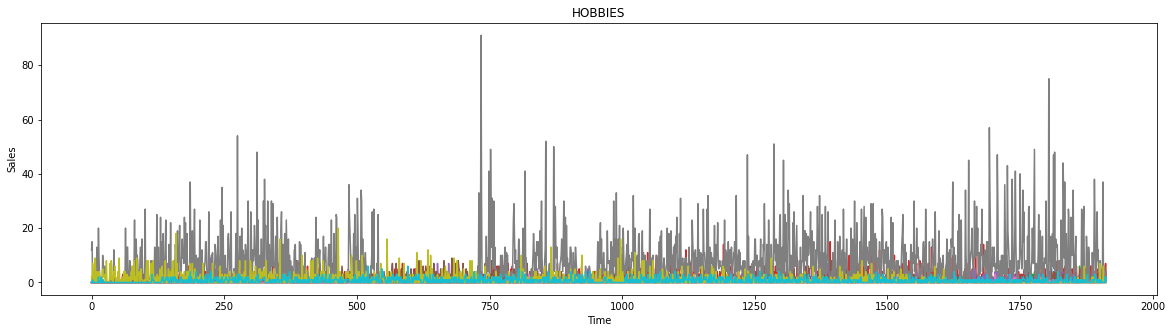

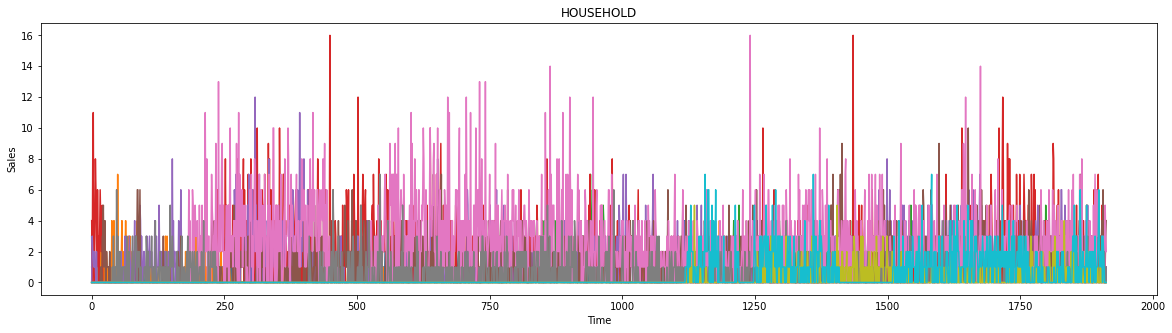

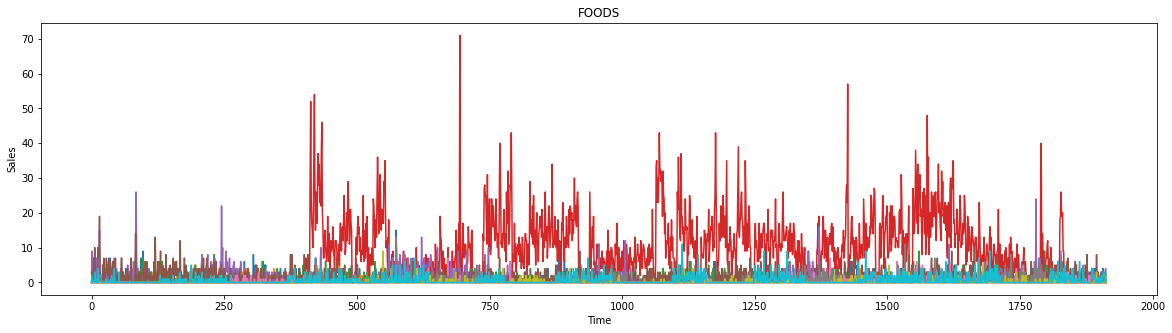

In [55]:
for i in train_sales.cat_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.cat_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

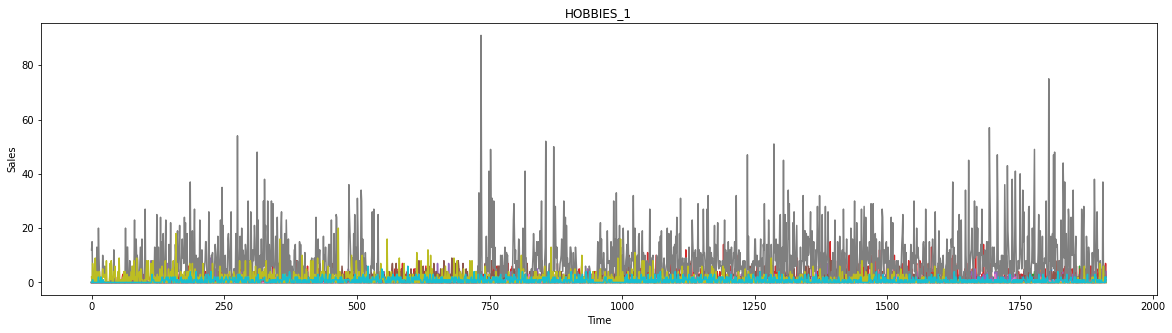

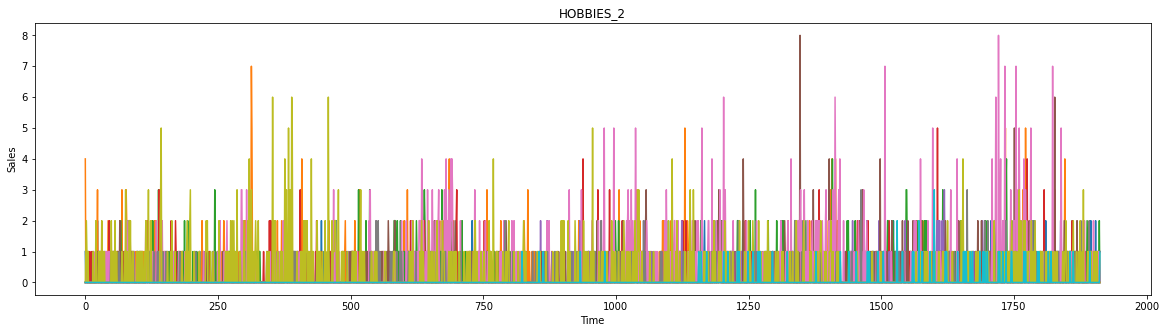

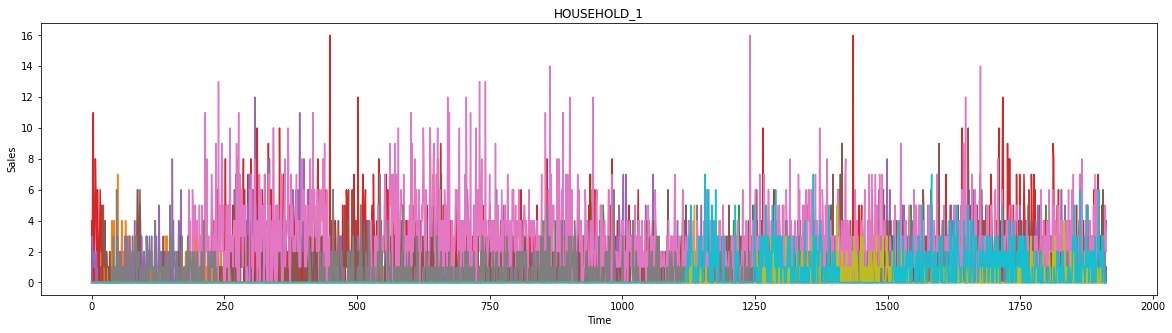

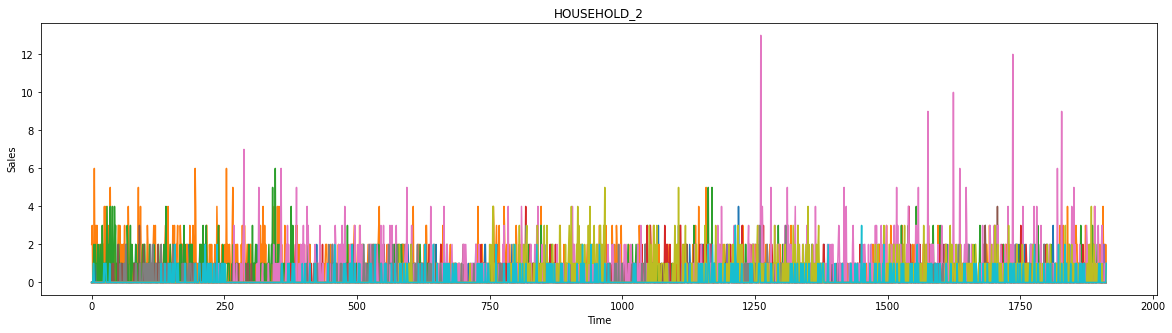

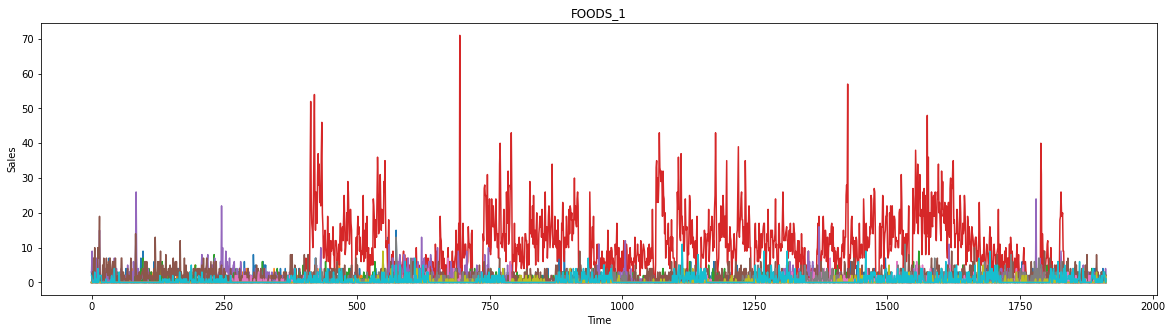

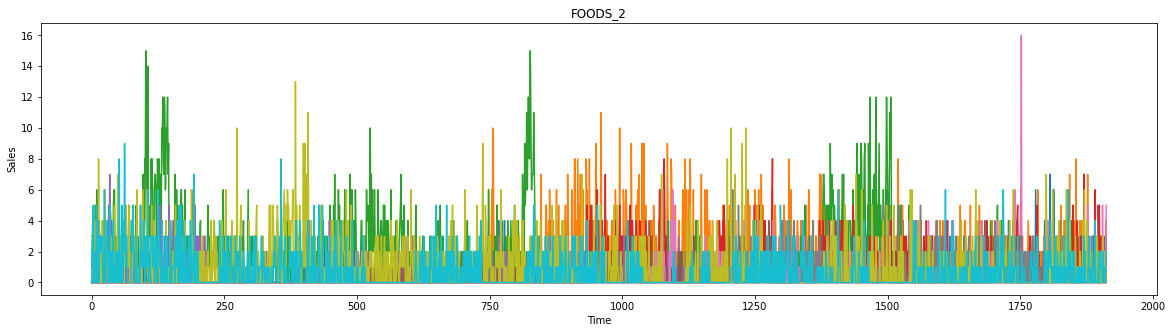

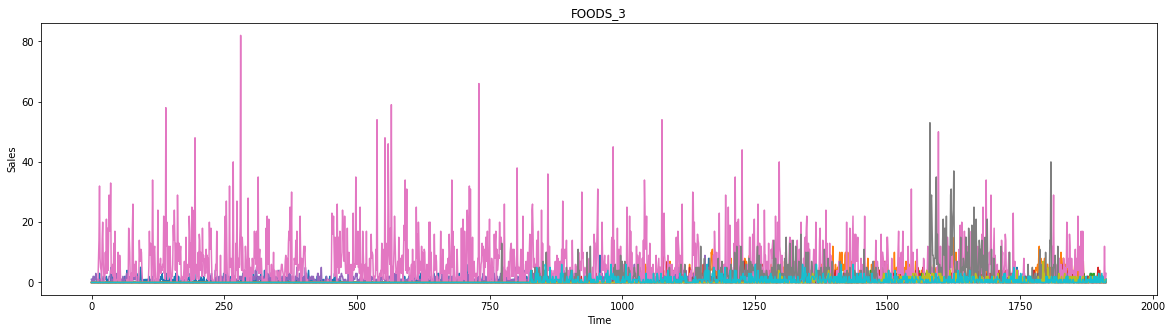

In [56]:
for i in train_sales.dept_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.dept_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

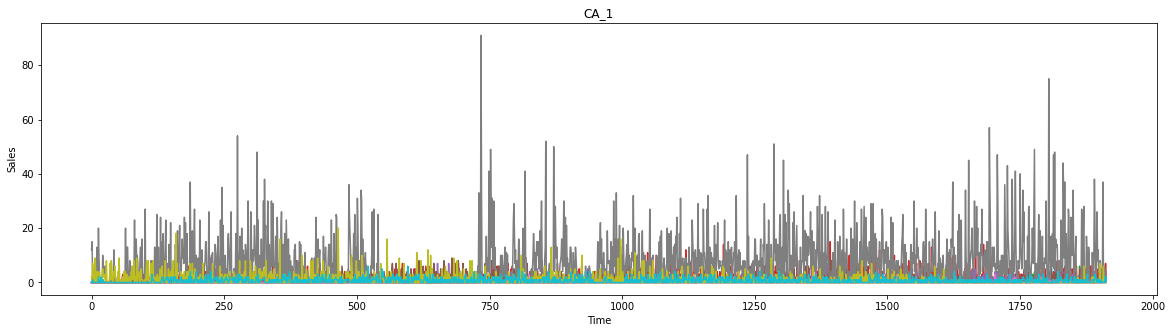

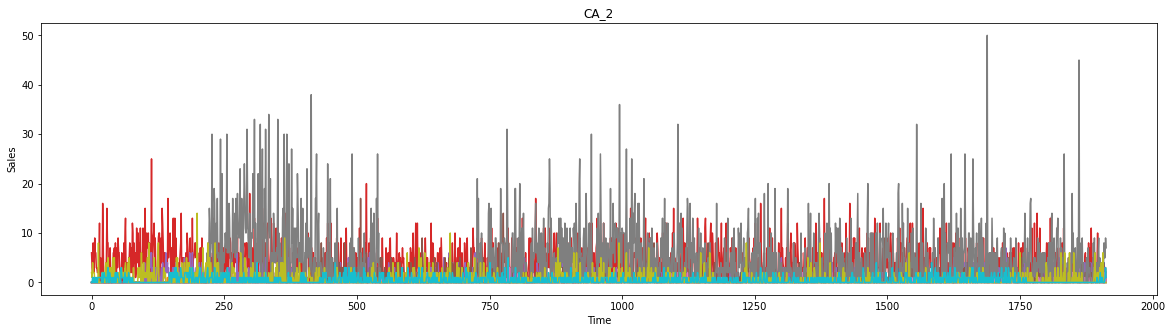

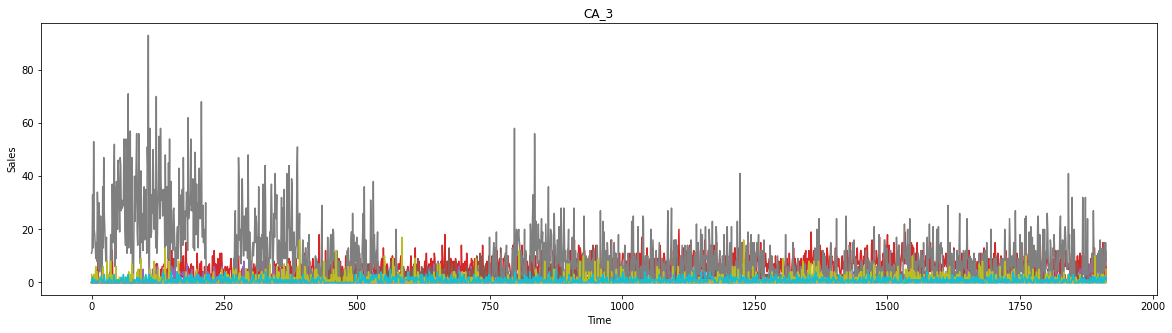

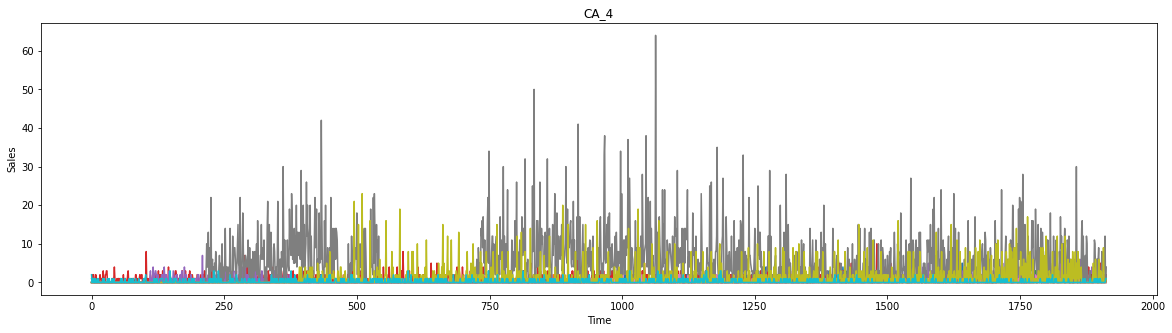

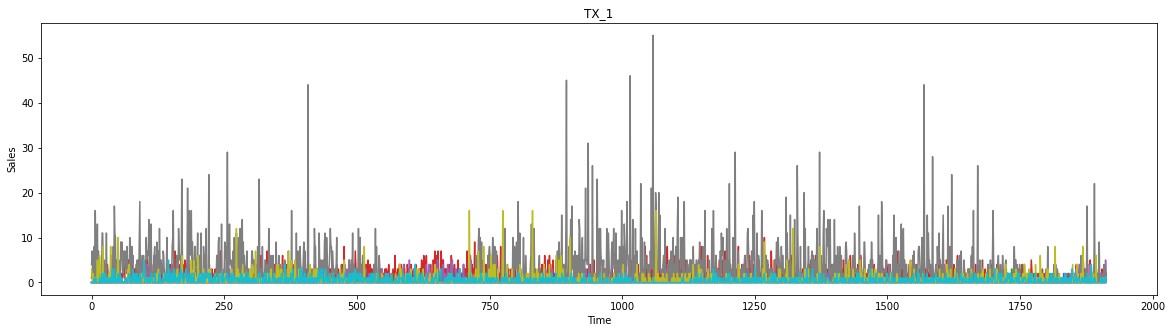

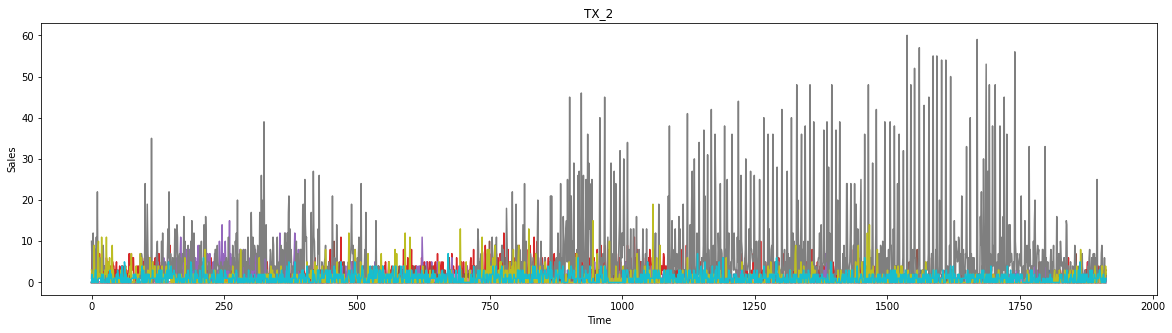

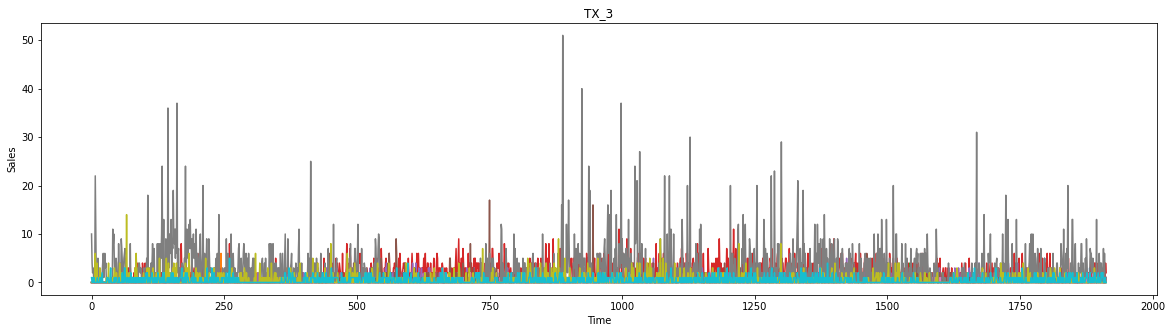

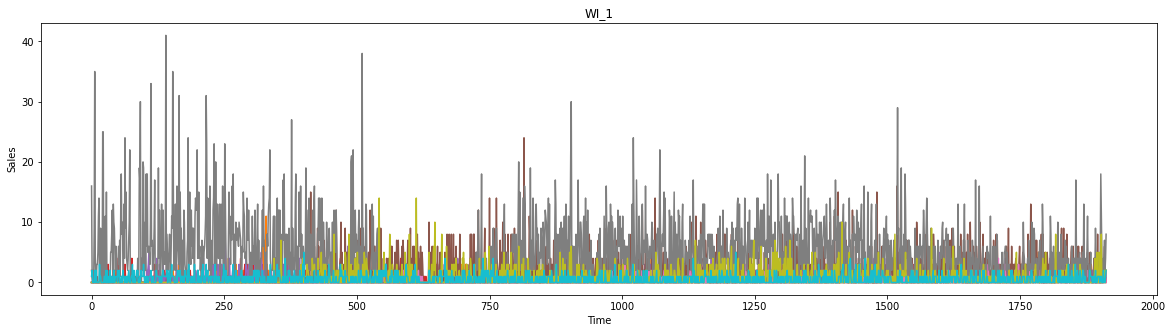

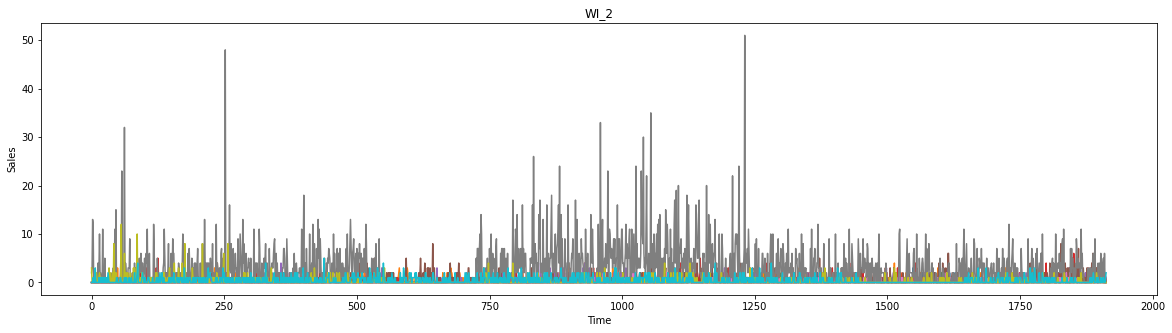

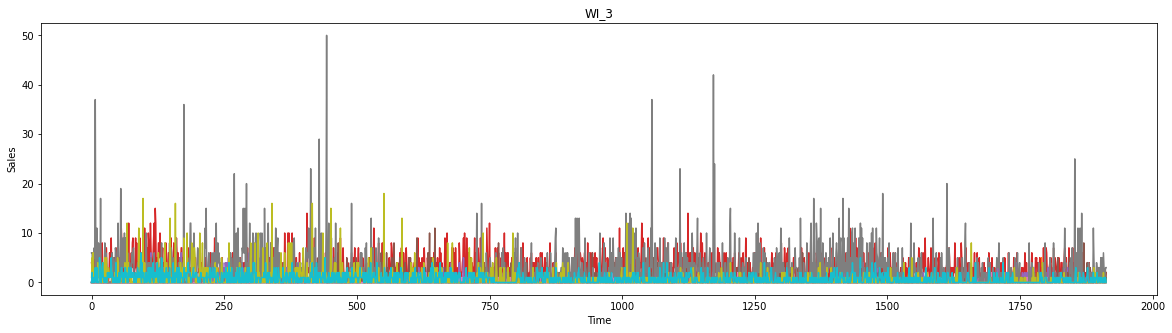

In [57]:
for i in train_sales.store_id.unique():
    fig =plt.figure(figsize= (20, 5))
    for j in range(10):
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(train_sales[train_sales.store_id==i].iloc[j, :][time_series_columns].values)
        ax.set_title(str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Sales')

In [59]:
X = []

In [60]:
for i in tqdm(range(time_series_data.shape[0])):
    X.append([list(t) for t in zip(transfer_cal.loc['event_name_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_type_1'][-(100+28):-(28)],
                                   transfer_cal.loc['event_name_2'][-(100+28):-(28)],     #emmmm.....Those features didn't work for me...
                                   transfer_cal.loc['event_type_2'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_CA'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_TX'][-(100+28):-(28)],
                                   transfer_cal.loc['snap_WI'][-(100+28):-(28)],
                                   price_df.iloc[i][-(100+28):-(28)],
                                   time_series_data.iloc[i][-100:])]) 

X = np.asarray(X, dtype=np.float32)

100%|███████████████████████████████████████████████████████████████████████████| 30490/30490 [01:11<00:00, 428.68it/s]


In [61]:
def Normalize(list):
    list = np.array(list)
    low, high = np.percentile(list, [0, 100])
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list,low,high

def FNoramlize(list,low,high):
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = list[i]*delta + low
    return list

def Normalize2(list,low,high):
    list = np.array(list)
    delta = high - low
    if delta != 0:
        for i in range(0, len(list)):
            list[i] = (list[i]-low)/delta
    return  list

In [62]:
np.random.seed(7)

 ## I only use the last 56 days for train_data.
if __name__ == '__main__':
    n_steps = 28
    train_n,train_low,train_high = Normalize(X[:,-(n_steps*2):,:])
    X_train = train_n[:,-28*2:-28,:]
    y = train_n[:,-28:,8]  #     
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 9
    n_out_seq_length =28
    num_y = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y = y.reshape((y.shape[0], y.shape[1], 1))
    print(X_train.shape)
    # define model

    model = Sequential()

    
    model.add(LSTM(128, activation='relu', input_shape=(28, n_features),return_sequences=False))
    model.add(RepeatVector(n_out_seq_length))
    model.add(LSTM(32, activation='relu',return_sequences=True))
   #model.add(Dropout(0.1))  
    model.add(TimeDistributed(Dense(num_y)))   # num_y means the shape of y,in some problem(like translate), it can be many.
                                                #In that case, you should set the  activation= 'softmax'
    model.compile(optimizer='adam', loss='mse')
    # demonstrate prediction
    model.fit(X_train, y, epochs=10, batch_size=1000)

(30490, 28, 9)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
30490/30490 [==============================] - ETA: 40s - loss: 3.7892e- - ETA: 26s - loss: 2.5734e- - ETA: 19s - loss: 2.6761e- - ETA: 16s - loss: 2.3596e- - ETA: 14s - loss: 2.1901e- - ETA: 13s - loss: 2.0742e- - ETA: 12s - loss: 1.9906e- - ETA: 11s - loss: 1.9622e- - ETA: 10s - loss: 2.0126e- - ETA: 9s - loss: 1.9324e-04 - ETA: 9s - loss: 1.9122e-0 - ETA: 8s - loss: 1.8599e-0 - ETA: 7s - loss: 1.7967e-0 - ETA: 7s - loss: 1.7939e-0 - ETA: 6s - loss: 1.7707e-0 - ETA: 6s - loss: 1.7658e-0 - ETA: 5s - loss: 1.7228e-0 - ETA: 5s - loss: 1.7064e-0 - ETA: 4s - loss: 1.6849e-0 - ETA: 4s - loss: 1.6752e-0 - ETA: 3s - loss: 1.6782e-0 - ETA: 3s - loss: 1.6553e-0 - ETA: 3s - loss: 1.6187e-0 - ETA: 2s - loss: 1.5869e-0 - ETA: 2s - loss: 1.5728e-0 - ETA: 1s - loss: 1.5497e-0 - ETA: 1s - loss: 1.5274e-0 - ETA: 1s - loss: 1.5048e-0 - ETA: 0s - loss: 1.4962

30490/30490 [==============================] - ETA: 11s - loss: 6.6898e- - ETA: 10s - loss: 7.5567e- - ETA: 9s - loss: 8.4975e-05 - ETA: 9s - loss: 7.9629e-0 - ETA: 9s - loss: 8.2848e-0 - ETA: 8s - loss: 8.0905e-0 - ETA: 8s - loss: 7.9564e-0 - ETA: 8s - loss: 8.0193e-0 - ETA: 7s - loss: 8.5721e-0 - ETA: 7s - loss: 8.3951e-0 - ETA: 7s - loss: 8.2916e-0 - ETA: 6s - loss: 8.2246e-0 - ETA: 6s - loss: 8.2546e-0 - ETA: 5s - loss: 8.3639e-0 - ETA: 5s - loss: 8.2803e-0 - ETA: 5s - loss: 8.1951e-0 - ETA: 4s - loss: 8.3231e-0 - ETA: 4s - loss: 8.1820e-0 - ETA: 4s - loss: 8.0576e-0 - ETA: 3s - loss: 8.0432e-0 - ETA: 3s - loss: 8.0132e-0 - ETA: 3s - loss: 8.0547e-0 - ETA: 2s - loss: 8.1024e-0 - ETA: 2s - loss: 8.1129e-0 - ETA: 2s - loss: 8.0730e-0 - ETA: 1s - loss: 8.1211e-0 - ETA: 1s - loss: 8.0411e-0 - ETA: 0s - loss: 7.9684e-0 - ETA: 0s - loss: 7.9246e-0 - ETA: 0s - loss: 7.9395e-0 - 11s 366us/step - loss: 7.9045e-05
Epoch 10/10
30490/30490 [==============================] - ETA: 10s - loss: 1.

In [63]:
x_input = array(X_train[:,-n_steps*1:])
x_input = x_input.reshape((num, n_steps*1, n_features))
print(x_input.shape)
#x_input = Normalize2(x_input,train_low,train_high)
yhat = model.predict(x_input[:,-n_steps:], verbose=0)
x_input=np.concatenate((x_input[:,:,8].reshape(x_input.shape[0],x_input.shape[1]),yhat.astype(np.float32).reshape(x_input.shape[0],x_input.shape[1])),axis=1).reshape((x_input.shape[0],x_input.shape[1]+28,1))
#print(yhat)
print(x_input.shape)

(30490, 28, 9)
(30490, 56, 1)


In [64]:
x_input = FNoramlize(x_input,train_low,train_high)
x_input = np.rint(x_input)

In [65]:
forecast = pd.DataFrame(x_input.reshape(x_input.shape[0],x_input.shape[1])).iloc[:,-28:]
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
forecast[forecast < 0] =0
forecast.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [66]:
validation_ids = train_sales['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]

In [67]:
ids = np.concatenate([validation_ids, evaluation_ids])

In [68]:
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast]*2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)

In [70]:
predictions.to_csv('submission_lstm.csv', index=False)  #Generate the csv file.